In [1]:
# general
import warnings
from tqdm import tqdm
from datasets import load_dataset, Dataset
import time
from collections import defaultdict
from transforms.PermuteImage import PermuteImage
from os.path import isfile

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
from torch.nn import Module
import cv2
from torch import nn, Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from modules.HeadlessPretrainedModule import HeadlessPretrainedModule
from modules.CustomModule import CustomModule
from modules.CustomModule import CustomModule2
from transforms.Transform_Builder import Transform_Builder
from modules.VitModule import VitModule

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

## Load the dataset

In [4]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

In [5]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [6]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

In [7]:
def transform_datasets(datasets: tuple[Dataset], transform = callable):
    return (dataset.with_transform(transform) for dataset in datasets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


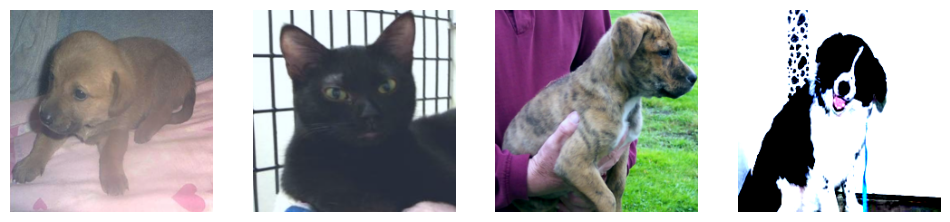

In [38]:
# def denormalize(tensor, mean, std):
#     tensor = tensor.clone()
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)
#     return tensor

# # Get a batch of training data
# iter = next(dataiter)
# images, labels = iter['image'].clone(), iter['labels']

# # Denormalize images for visualization
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# images = denormalize(images, mean, std)

# # Plot images
# fig, axes = plt.subplots(1, 4, figsize=(12, 3))
# for i in range(4):
#     img = images[i]
#     img = np.transpose(img.numpy(), (1, 2, 0))  # Transpose to (H, W, C)
#     axes[i].imshow(img)
#     axes[i].axis('off')
# plt.show()

#### 1. Pretrained model baseline

In [22]:
pretrained_transform = Transform_Builder.build(size=224)
train_set, val_set, test_set = transform_datasets((train, val, test), transform=pretrained_transform)

In [24]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [25]:
pretrained_model = HeadlessPretrainedModule(pretrained_model = models.resnet50(pretrained=True), device=device)
pretrained_model = pretrained_model.to(device)

In [26]:
if isfile("./pretrained_model.pth"):
    pretrained_model.load_state_dict(torch.load("./pretrained_model.pth"))
else:
    lr = 5e-3
    num_epochs = 5

    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    pretrained_model.start_train(criterion, optimizer, dataloaders)
    torch.save(pretrained_model.state_dict(), "./pretrained_model.pth")

In [19]:
pretrained_model.predict_data(dataloaders['test'])

Test Acc: 0.986979


##### 1.2 Evaluating premuted images

In [10]:
num_tiles_options = [4,9,16,25,36]

In [91]:
def run_verious_tile_test(size:int, num_tiles_options: list , model : Module):
    results = {"Tiles": [], "Accuracy": []}
    for num_tiles in num_tiles_options:
        transform_with_premute = Transform_Builder.build(size=size, with_premute=True, num_tiles=num_tiles)
        premuted_test_set = test.with_transform(transform_with_premute)
        premuted_dataloader = DataLoader(premuted_test_set, batch_size=32, drop_last=True, num_workers=0)
        model.predict_data(premuted_dataloader)
        results["Tiles"].append(num_tiles)
        results["Accuracy"].append(model.test_acc)
    return results

In [92]:
pretrained_results = run_verious_tile_test(224, num_tiles_options , pretrained_model)

Test Acc: 0.953993
Test Acc: 0.914062
Test Acc: 0.882812
Test Acc: 0.790799
Test Acc: 0.729167


In [12]:
def draw_bar_plot(data, x,y, title, figsize=(6,3)):
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.barplot(data = data, y=y, x=x, palette='pastel',  legend=False, ax=ax)
    for i in g.containers:
        g.bar_label(i, padding=-20, fmt='%.3f')
    plt.title(title);
    plt.tight_layout()
    plt.show()

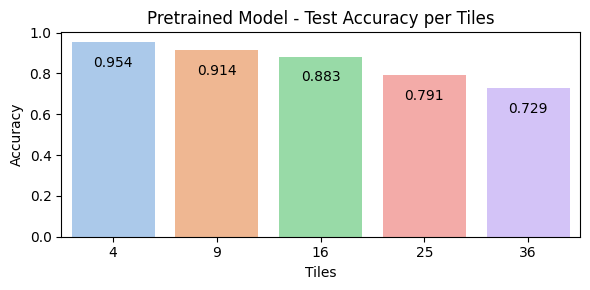

In [93]:
draw_bar_plot(data= pd.DataFrame(pretrained_results), y='Accuracy', x='Tiles', title='Pretrained Model - Test Accuracy per Tiles')

#### 2. Custom model baseline

In [37]:
custom_transform = Transform_Builder.build(size=100)
train_set, val_set, test_set = transform_datasets((train, val, test), transform=custom_transform)
custom_dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [38]:
custom_model = CustomModule2(device=device)
custom_model = custom_model.to(device)

In [39]:
if isfile("./CustomModel.pth"):
    custom_model.load_state_dict(torch.load("./CustomModel.pth"))
else:
    lr = 1e-3
    num_epochs = 30

    optimizer = torch.optim.Adam(custom_model.parameters(), lr)
    criterion = nn.CrossEntropyLoss()
    custom_model.start_train(criterion, optimizer, dataloaders, num_epochs=num_epochs)
    torch.save(custom_model.state_dict(), "./CustomModel.pth")

In [40]:
custom_model.predict_data(custom_dataloaders['test'])

Test Acc: 0.921007


##### 2.2 Evaluating premuted images

In [48]:
custom_results = run_verious_tile_test(100, num_tiles_options , custom_model)

Test Acc: 0.660590
Test Acc: 0.627604
Test Acc: 0.611979
Test Acc: 0.596354
Test Acc: 0.565972


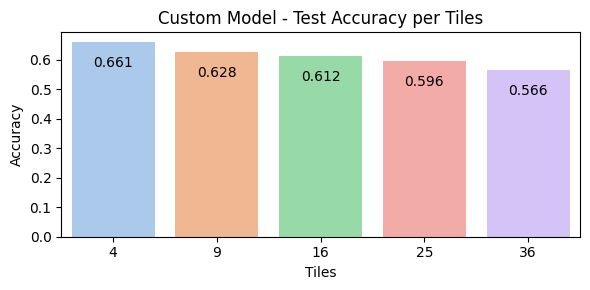

In [49]:
draw_bar_plot(data= pd.DataFrame(custom_results), y='Accuracy', x='Tiles', title='Custom Model - Test Accuracy per Tiles')

##### 2.3 Getting correctly predicted Images out of test set

In [53]:
test_images = splitted_dataset['test']['image']
tp_test_images = [test_images[i] for i in torch.argwhere(match)]

In [171]:
test_labels = splitted_dataset['test']['labels']
tp_test_labels = [test_labels[i] for i in torch.argwhere(match)]


In [185]:
from datasets import Dataset

dataset2 = Dataset.from_dict({'image': test_images, 'labels': test_labels})

#### 3. Vit Model Baseline

In [7]:
Vit_model = VitModule('nateraw/vit-base-cats-vs-dogs', device)

In [15]:
def vit_transform(example_batch):
    lst = []
    if example_batch.get('image'):
        for img in example_batch['image']:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            lst.append(img)
    example_batch['image'] = Vit_model.processor(lst, return_tensors='pt')['pixel_values']
    example_batch['labels'] = torch.tensor(example_batch['labels'], dtype=torch.int64) 
    return example_batch

In [17]:
test_set = test.with_transform(vit_transform)
test_loader = DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0)

In [18]:
Vit_model.predict_data(test_loader)

Test Acc: 0.998300


In [8]:
def build_transform_with_premute(num_tiles= 4):

    def transform(example_batch):
        lst = []
        if example_batch.get('image'):
            for img in example_batch['image']:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = PermuteImage(num_tiles)(img)
                lst.append(img)
        # Take a list of PIL images and turn them to pixel values
        example_batch['image'] = Vit_model.processor(lst, return_tensors='pt')['pixel_values']

        # Don't forget to include the labels!
        example_batch['labels'] = torch.tensor(example_batch['labels'], dtype=torch.int64) 
        return example_batch
    return transform


In [11]:
vit_results = {"Tiles": [], "Accuracy": []}
for num_tiles in num_tiles_options:
    vit_transform_with_premute = build_transform_with_premute(num_tiles)
    vit_premuted_test_set = test.with_transform(vit_transform_with_premute)
    vit_premuted_dataloader = DataLoader(vit_premuted_test_set, batch_size=32, drop_last=True, num_workers=0)
    Vit_model.predict_data(vit_premuted_dataloader)
    vit_results["Tiles"].append(num_tiles)
    vit_results["Accuracy"].append(Vit_model.test_acc)

Test Acc: 0.994800
Test Acc: 0.991300
Test Acc: 0.975700
Test Acc: 0.954900
Test Acc: 0.941800


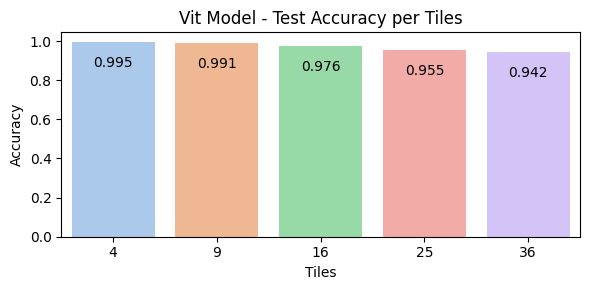

In [13]:
draw_bar_plot(data= pd.DataFrame(vit_results), y='Accuracy', x='Tiles', title='Vit Model - Test Accuracy per Tiles')